# 4 - AutoEncoders

In [49]:
# %pip install kagglehub
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("zalando-research/fashionmnist")

# print("Path to dataset files:", path)

In [50]:
%pip install -q tensorflow



Note: you may need to restart the kernel to use updated packages.


### 4 - 1 Normalization and Preprocessing

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from keras.datasets import mnist
from tensorflow.keras import layers, losses, optimizers
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import mode
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import math
from tensorflow.keras.datasets import fashion_mnist


In [52]:

SEED = 0

np.random.seed(SEED)
tf.random.set_seed(SEED)




In [53]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))



In [54]:

class Auto_Encoder:
    def __init__(self, encoder_layers, decoder_layers, latent_dimensions):
        input_dim = 28 * 28
        self.encoder = tf.keras.Sequential()
        self.encoder.add(layers.Input(shape=(28, 28, 1)))
        self.encoder.add(layers.Flatten())
        
        encoder_dims = tf.linspace(float(input_dim), float(latent_dimensions), encoder_layers + 1)
        print(encoder_dims)
        encoder_dims = [int(d) for d in encoder_dims[1:]]
        for dim in encoder_dims:
            self.encoder.add(layers.Dense(dim, activation='relu'))

        self.decoder = tf.keras.Sequential()
        decoder_dims = tf.linspace(float(latent_dimensions), float(input_dim), decoder_layers + 1)
        decoder_dims = [int(d) for d in decoder_dims[1:]]
        for dim in decoder_dims[:-1]:
            self.decoder.add(layers.Dense(dim, activation='relu'))
        self.decoder.add(layers.Dense(28 * 28, activation='relu'))
        self.decoder.add(layers.Reshape((28, 28, 1)))
        self.training_losses = []

    
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def train(self, X_train, n_epochs=10, batch_size=64, learning_rate=0.001):
        train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1024).batch(batch_size)
        loss_fn = losses.MeanSquaredError()
        optimizer = optimizers.AdamW(learning_rate=learning_rate)
        
        for epoch in range(n_epochs):
            print(f"\nEpoch {epoch + 1}/{n_epochs}")
            epoch_loss = tf.metrics.Mean()

            for batch in train_dataset:
                with tf.GradientTape() as tape:
                    reconstructed = self.forward(batch)
                    loss = loss_fn(batch, reconstructed)

                grads = tape.gradient(
                    loss,
                    self.encoder.trainable_variables + self.decoder.trainable_variables
                )
                optimizer.apply_gradients(
                    zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables)
                )

                epoch_loss.update_state(loss)
            print(f"Training Loss: {epoch_loss.result()}")
            epoch_loss_value = epoch_loss.result().numpy()
            self.training_losses.append(epoch_loss_value)


        plt.figure(figsize=(6, 4))
        plt.plot(range(1, n_epochs + 1), self.training_losses, marker='o')
        plt.title("AutoEncoder Training Loss (MSE) per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Mean Squared Error")
        plt.grid(True)
        plt.show()





tf.Tensor([784.      565.3333  346.66666 128.     ], shape=(4,), dtype=float32)

Epoch 1/5
Training Loss: 0.02540353685617447

Epoch 2/5
Training Loss: 0.01470095943659544

Epoch 3/5
Training Loss: 0.012616736814379692

Epoch 4/5
Training Loss: 0.011538052931427956

Epoch 5/5
Training Loss: 0.01092104148119688


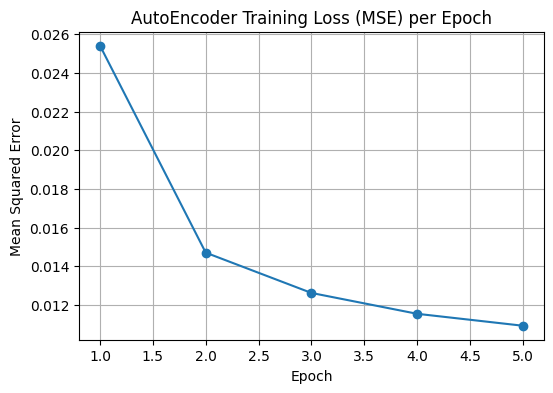

In [55]:

tf.config.optimizer.set_jit(True)
auto_encoder = Auto_Encoder(encoder_layers=3, decoder_layers=3, latent_dimensions=128)
auto_encoder.train(n_epochs = 5, batch_size=64, learning_rate = 0.001, X_train = X_train)
encoded_imgs = auto_encoder.encoder(X_test).numpy()
decoded_imgs = auto_encoder.decoder(encoded_imgs).numpy()



### Display images of different classes

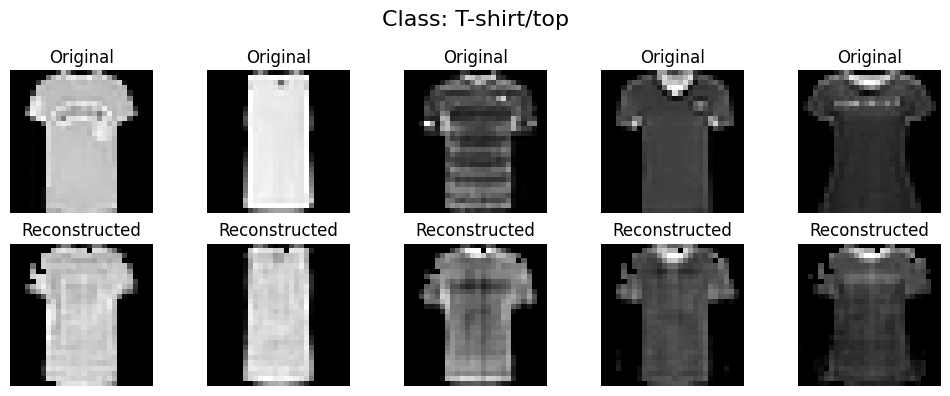

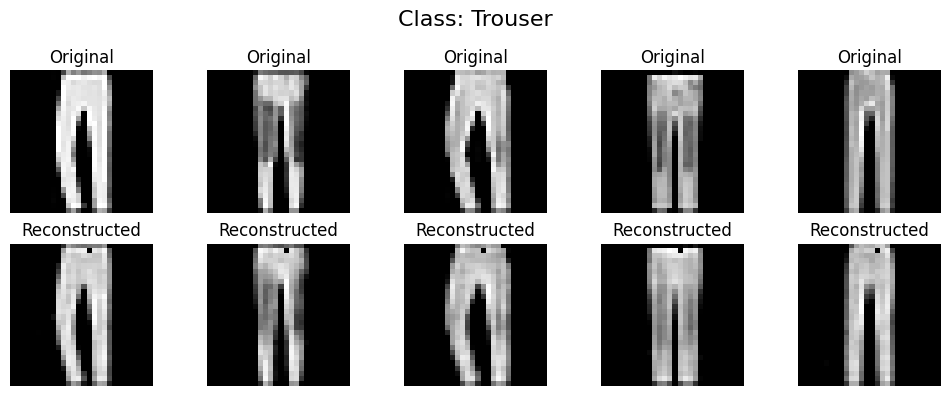

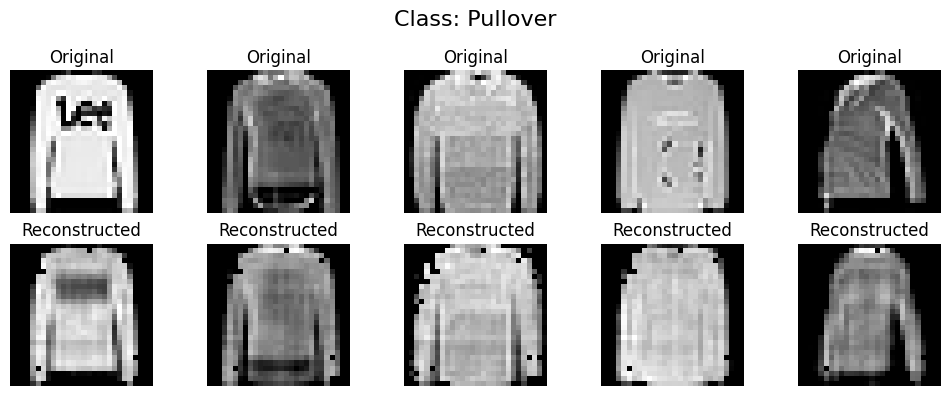

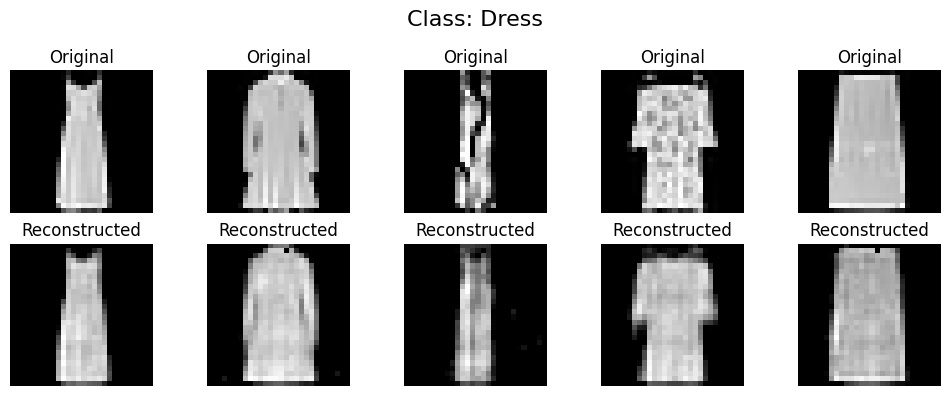

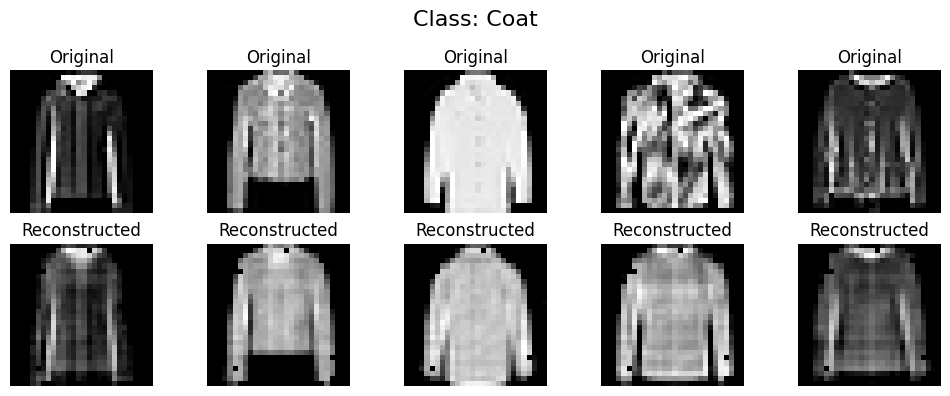

In [56]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

chosen_classes = [0, 1, 2, 3, 4]
decoded_imgs = auto_encoder.forward(X_test).numpy()

for class_id in chosen_classes:
    indices = np.where(y_test == class_id)[0][:5]

    plt.figure(figsize=(10, 4))
    plt.suptitle(f"Class: {class_names[class_id]}", fontsize=16)

    for j, i in enumerate(indices):
        ax = plt.subplot(2, 5, j + 1)
        plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        ax = plt.subplot(2, 5, j + 6)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()



### Cluster encoded data using K-means

In [57]:


encoded_data = auto_encoder.encoder(X_test).numpy() 
print("Encoded data shape:", encoded_data.shape)
kmeans = KMeans(n_clusters=10, n_init=50, random_state=SEED)
kmeans.fit(encoded_data)


Encoded data shape: (10000, 128)


KMeans(n_clusters=10, n_init=50, random_state=0)

In [58]:

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
cluster_labels = kmeans.fit_predict(encoded_imgs)


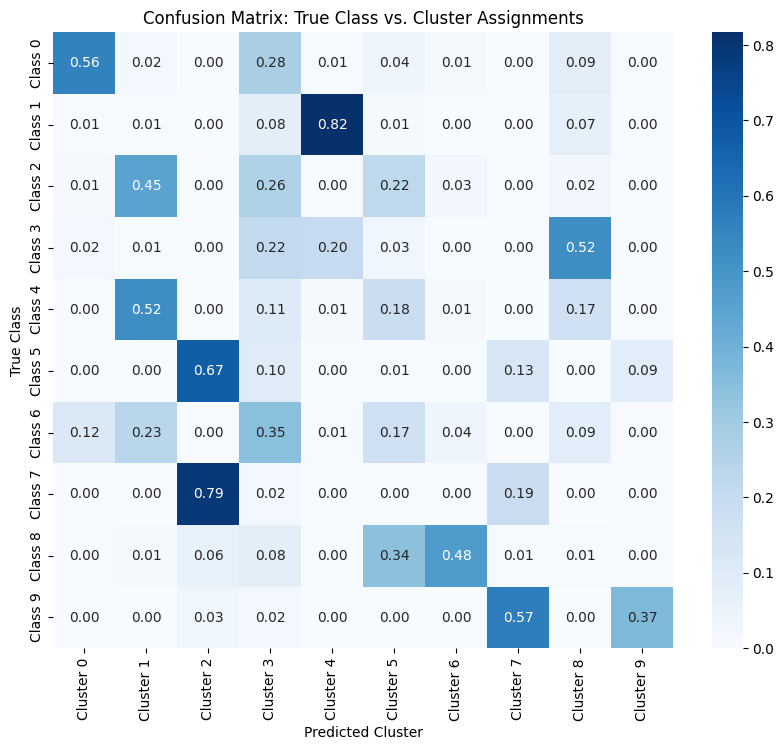

In [68]:

cm = confusion_matrix(y_test, cluster_labels)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f"Cluster {i}" for i in range(n_clusters)],
            yticklabels=[f"Class {i}" for i in range(10)])
plt.xlabel("Predicted Cluster")
plt.ylabel("True Class")
plt.title("Confusion Matrix: True Class vs. Cluster Assignments")
plt.show()


In [ ]:


cluster_to_class = {}
for cluster in range(n_clusters):
    mask = cluster_labels == cluster
    if np.any(mask):
        cluster_to_class[cluster] = mode(y_test[mask], keepdims=True)[0][0]

print("Cluster to class Mapping:")
print(cluster_to_class)


Cluster to Digit Mapping:
{0: 0, 1: 4, 2: 7, 3: 6, 4: 1, 5: 8, 6: 8, 7: 9, 8: 3, 9: 9}


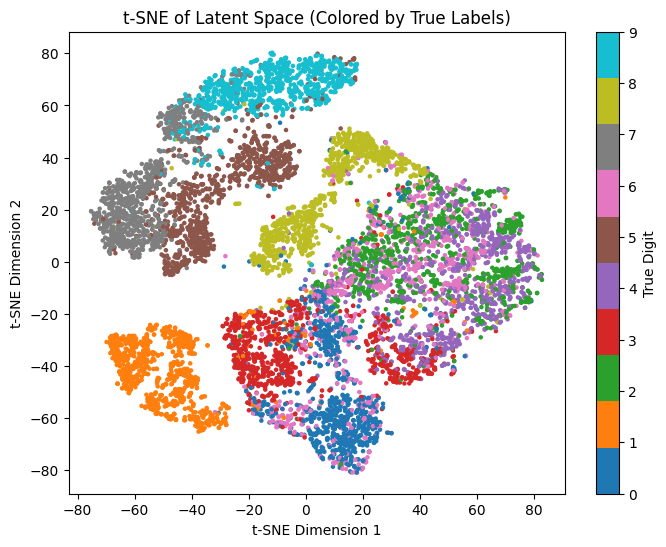

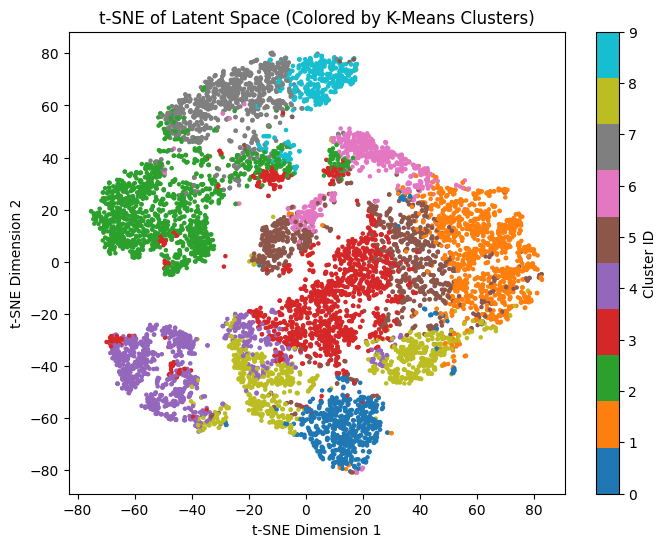

In [ ]:


tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=SEED)
encoded_tsne = tsne.fit_transform(encoded_imgs)

plt.figure(figsize=(8, 6))
scatter1 = plt.scatter(encoded_tsne[:, 0], encoded_tsne[:, 1],
                       c=y_test, cmap='tab10', s=5)
plt.colorbar(scatter1, ticks=range(10), label="True class")
plt.title("t-SNE of Latent Space (Colored by True Labels)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

plt.figure(figsize=(8, 6))
scatter2 = plt.scatter(encoded_tsne[:, 0], encoded_tsne[:, 1],
                       c=cluster_labels, cmap='tab10', s=5)
plt.colorbar(scatter2, ticks=range(10), label="Cluster ID")
plt.title("t-SNE of Latent Space (Colored by K-Means Clusters)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


### t-SNE, K-means and Confusion matrix for raw data

In [69]:
X_test= X_test.reshape(len(X_test), -1)
n_clusters = 10
kmeans_raw = KMeans(n_clusters=n_clusters, n_init=20, random_state=SEED)
cluster_labels_raw = kmeans_raw.fit_predict(X_test)

cluster_to_class_raw = {}
for cluster in range(n_clusters):
    mask = cluster_labels_raw == cluster
    if np.any(mask):
        cluster_to_class_raw[cluster] = mode(y_test[mask], keepdims=True)[0][0]

print("Cluster → Class Mapping (Raw Data):")
print(cluster_to_class_raw)

Cluster → Class Mapping (Raw Data):
{0: 1, 1: 4, 2: 5, 3: 9, 4: 6, 5: 0, 6: 9, 7: 8, 8: 7, 9: 8}


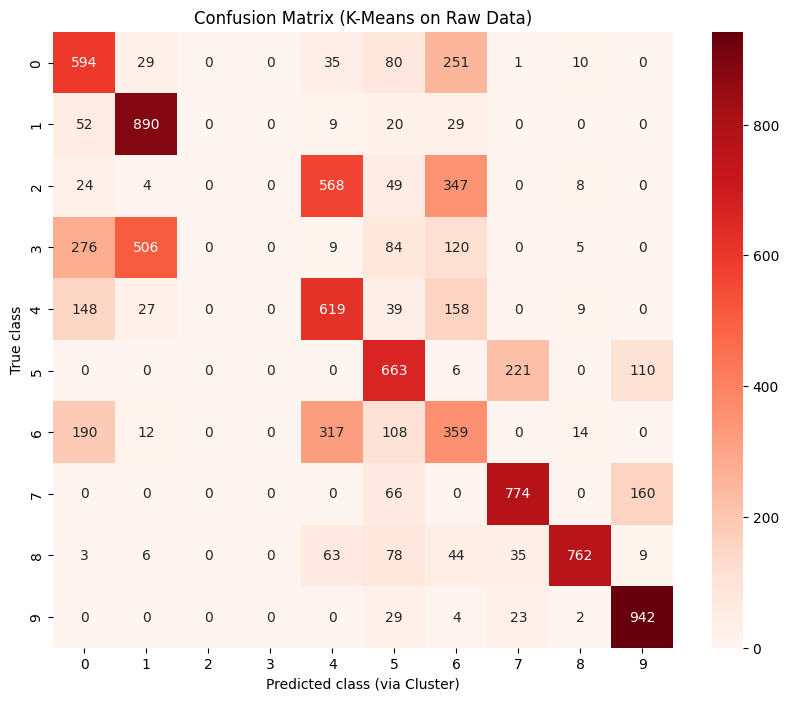

In [71]:
mapped_preds_raw = np.array([cluster_to_class_raw[c] for c in cluster_labels_raw])
cm_raw = confusion_matrix(y_test, mapped_preds_raw)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_raw, annot=True, fmt="d", cmap="Reds",
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.xlabel("Predicted class (via Cluster)")
plt.ylabel("True class")
plt.title("Confusion Matrix (K-Means on Raw Data)")
plt.show()

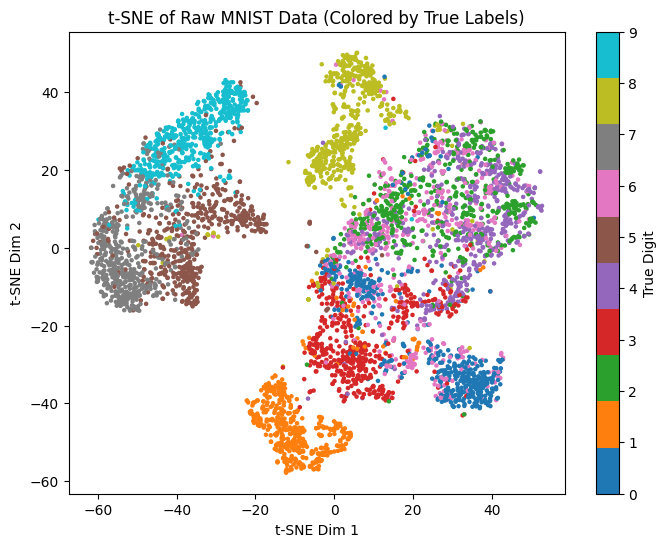

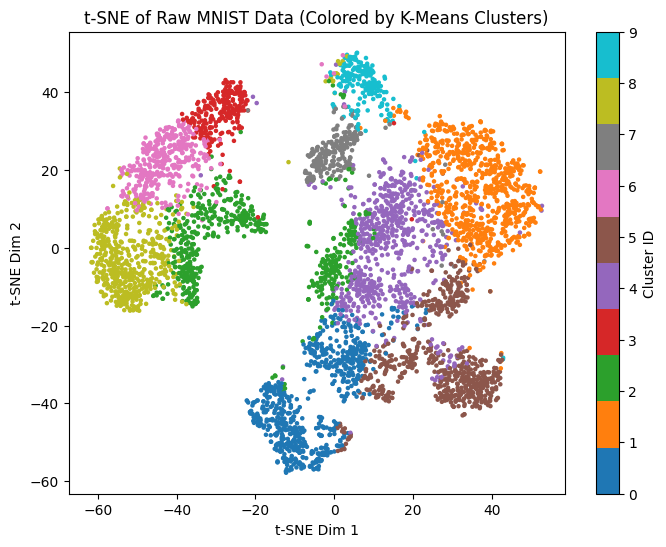

In [ ]:
subset_size = 5000
idx = np.random.choice(len(X_test), subset_size, replace=False)
X_subset = X_test[idx]
y_subset = y_test[idx]
cluster_subset = cluster_labels_raw[idx]

tsne_raw = TSNE(n_components=2, perplexity=50, learning_rate=200, random_state=SEED)
X_tsne_raw = tsne_raw.fit_transform(X_subset)

plt.figure(figsize=(8, 6))
scatter1 = plt.scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1],
                       c=y_subset, cmap='tab10', s=5)
plt.colorbar(scatter1, ticks=range(10), label="True class")
plt.title("t-SNE of Raw MNIST Data (Colored by True Labels)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

plt.figure(figsize=(8, 6))
scatter2 = plt.scatter(X_tsne_raw[:, 0], X_tsne_raw[:, 1],
                       c=cluster_subset, cmap='tab10', s=5)
plt.colorbar(scatter2, ticks=range(10), label="Cluster ID")
plt.title("t-SNE of Raw MNIST Data (Colored by K-Means Clusters)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

### 4.4.6 Implement Adjusted Rand Index and Adjusted mutual information by hand


In [65]:
def C_2_of_n(x):
    if x < 2:
        return 0
    return x * (x - 1) // 2

def adjusted_rand_index(preds_A, preds_B):
    assert len(preds_A) == len(preds_B)
    n_preds = len(preds_A)
    
    unique_A = []
    unique_B = []
    for i in range(len(preds_A)):
        if preds_A[i] not in unique_A:
            unique_A.append(preds_A[i])
        if preds_B[i] not in unique_B:
            unique_B.append(preds_B[i])
            
    cluster_overlap = []
    for _ in range(len(unique_A)):
        cluster_overlap.append([0] * len(unique_B))

    for i in range(n_preds):
        a = preds_A[i]
        b = preds_B[i]
        a_idx = unique_A.index(a)
        b_idx = unique_B.index(b)
        cluster_overlap[a_idx][b_idx] += 1
        
    sum_comb = 0
    for i in range(len(cluster_overlap)):
        for j in range(len(cluster_overlap[i])):
            val = cluster_overlap[i][j]
            sum_comb += C_2_of_n(val)

    row_sums = []
    for i in range(len(cluster_overlap)):
        total = 0
        for j in range(len(cluster_overlap[i])):
            total += cluster_overlap[i][j]
        row_sums.append(total)

    col_sums = []
    for j in range(len(cluster_overlap[0])):
        total = 0
        for i in range(len(cluster_overlap)):
            total += cluster_overlap[i][j]
        col_sums.append(total)

    sum_comb_rows = 0
    for val in row_sums:
        sum_comb_rows += C_2_of_n(val)

    sum_comb_cols = 0
    for val in col_sums:
        sum_comb_cols += C_2_of_n(val)

    total_comb = C_2_of_n(n_preds)

    expected_index = (sum_comb_rows * sum_comb_cols) / total_comb
    max_index = 0.5 * (sum_comb_rows + sum_comb_cols)

    adjusted_index = (sum_comb - expected_index) / (max_index - expected_index)

    return adjusted_index
    
    

In [66]:
def adjusted_mutual_info(preds_A, preds_B):
    n = len(preds_A)

    unique_A = []
    unique_B = []
    for a in preds_A:
        if a not in unique_A:
            unique_A.append(a)
    for b in preds_B:
        if b not in unique_B:
            unique_B.append(b)

    cluster_overlap = []
    for i in range(len(unique_A)):
        cluster_overlap.append([0] * len(unique_B))

    for i in range(n):
        a = preds_A[i]
        b = preds_B[i]
        a_idx = unique_A.index(a)
        b_idx = unique_B.index(b)
        cluster_overlap[a_idx][b_idx] += 1

    row_sums = []
    for i in range(len(cluster_overlap)):
        total = 0
        for j in range(len(cluster_overlap[i])):
            total += cluster_overlap[i][j]
        row_sums.append(total)

    col_sums = []
    for j in range(len(cluster_overlap[0])):
        total = 0
        for i in range(len(cluster_overlap)):
            total += cluster_overlap[i][j]
        col_sums.append(total)

    mutual_information = 0.0
    for i in range(len(cluster_overlap)):
        for j in range(len(cluster_overlap[i])):
            joint_prob = cluster_overlap[i][j] / n        
            prob_u = row_sums[i] / n                 
            prob_v = col_sums[j] / n                 
            if joint_prob > 0:
                mutual_information += joint_prob * math.log(joint_prob / (prob_u * prob_v))

    entropy_U = 0.0
    for val in row_sums:
        prob_u = val / n
        if prob_u > 0:
            entropy_U -= prob_u * math.log(prob_u)

    entropy_V = 0.0
    for val in col_sums:
        prob_v = val / n
        if prob_v > 0:
            entropy_V -= prob_v * math.log(prob_v)

    adjusted_mutual_info_score = mutual_information / ((entropy_U + entropy_V) / 2)
    return adjusted_mutual_info_score


In [67]:
ari_clusters = adjusted_rand_index(cluster_labels, cluster_labels_raw)
ami_clusters = adjusted_mutual_info(cluster_labels, cluster_labels_raw)

print(f"ARI: {ari_clusters}")
print(f"AMI: {ami_clusters:}")


ARI: 0.545371567075987
AMI: 0.6889901591615293
